# Apply K-means clustering to the gene expression time series

## Warm up: K-means
I first do some warm up by coding up simple K-means clustering for a 2D data. Let me simulate three clusters of points, each of which are drawn from a multivariate normal distribution.

In [7]:
import numpy as np
mean1 = [2,2]
mean2 = [-2,2]
mean3 = [0,-2]
cov = [[0.8,0.2], [0.2, 0.8]]
samples_1 = np.random.multivariate_normal(mean1, cov, 30)
samples_2 = np.random.multivariate_normal(mean2, cov, 40)
samples_3 = np.random.multivariate_normal(mean3, cov, 20)

In [8]:
color_red="#db382c"
color_green="#2f7028"
color_brown="#665223"
color_blue="#344885"
color_magenta="#b538b3"

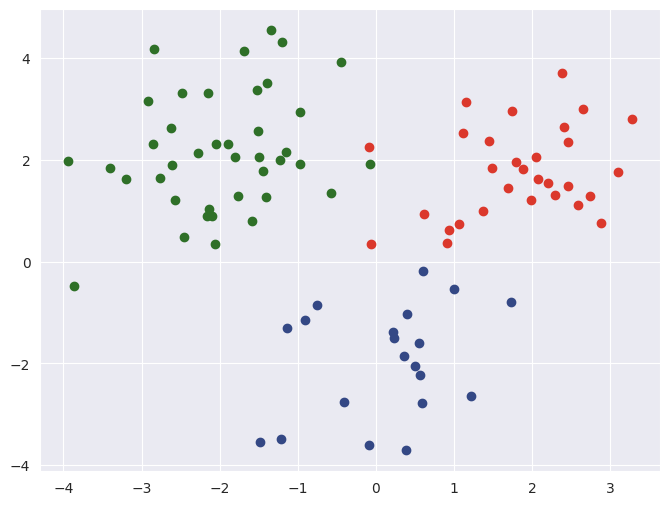

In [9]:
import matplotlib.pyplot as plt
fig1, ax1 = plt.subplots(figsize=(8, 6))
ax1.scatter(samples_1[:, 0], samples_1[:, 1], c=color_red)
ax1.scatter(samples_2[:, 0], samples_2[:, 1], c=color_green)
ax1.scatter(samples_3[:, 0], samples_3[:, 1], c=color_blue)


In [111]:
def mykmeans(points: np.ndarray, ncluster: int):

    # set initial centers
    quartiles = np.quantile(points, q=[0.25, 0.75], axis=0)
    centers = np.array([np.random.uniform(low=quartiles[0, j], high=quartiles[1, j], size=ncluster)
               for j in range(quartiles.shape[1])])
    centers = centers.transpose()


    # calculate initial distances and cluster labels
    distances_mat = np.zeros((points.shape[0], ncluster))
    for j in range(ncluster):
        center = centers[j, :]
        distances_mat[:, j] = np.sum(np.square(points - center[np.newaxis, :]), axis=1)
    labels = np.argmin(distances_mat, axis=1)

    # begin iteration
    num_iterations = 0
    while True:
        # calculate new center
        for j in range(ncluster):
            centers[j, :] = np.mean(points[labels == j, :], axis=0)
        # calculate new distances
        for j in range(ncluster):
            center = centers[j, :]
            distances_mat[:, j] = np.sum(np.square(points - center[np.newaxis, :]), axis=1)
        num_iterations += 1
        new_labels = np.argmin(distances_mat, axis=1)
        if np.all(new_labels == labels):
            break
        else:
            labels=new_labels

    return labels, num_iterations

In [20]:
all_samples = np.concatenate((samples_1, samples_2, samples_3), axis=0)

In [112]:
cluster_result, num_iter = mykmeans(all_samples, 3)
result = np.column_stack((all_samples, cluster_result))

In [113]:
uniq_vals, counts = np.unique(result[:, 2], return_counts=True)

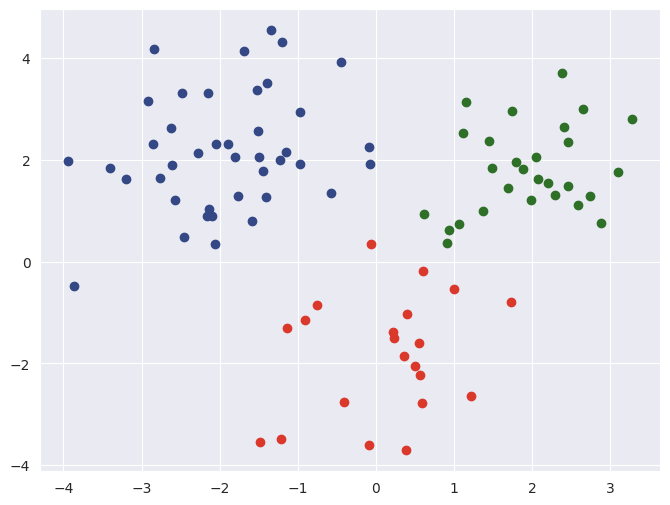

In [114]:
fig2, ax2 = plt.subplots(figsize=(8, 6))
fitted_samples_1 = result[result[:, 2] == 0, 0:2]
fitted_samples_2 = result[result[:, 2] == 1, 0:2]
fitted_samples_3 = result[result[:, 2] == 2, 0:2]
ax2.scatter(fitted_samples_1[:, 0], fitted_samples_1[:, 1], c=color_red)
ax2.scatter(fitted_samples_2[:, 0], fitted_samples_2[:, 1], c=color_green)
ax2.scatter(fitted_samples_3[:, 0], fitted_samples_3[:, 1], c=color_blue)

## K-means clustering for genes based on their expressions


In [60]:
import pandas as pd

In [61]:
expression_df = pd.read_csv("tpm.redSum.combat.ww.txt", sep='\t', index_col=0)

We are only going to look at the genes which are always expressed from month 2 to month 23.

In [62]:
all_timepoints = expression_df.columns.tolist()

In [63]:
# filter out the timepoints that belong to wildtypes
wildtype_pattern = "^\d+MO[a-e]"
import re
regex = re.compile(wildtype_pattern)
sample_names = [selected_time for selected_time in all_timepoints if regex.match(selected_time)]

In [64]:
expression_df = expression_df.loc[:, sample_names]

In [65]:
# extract the month numbers
def extract_number(mystring):
    numbers = re.findall("^\d+", mystring)
    return int(numbers[0])

In [66]:
time_month = np.array([extract_number(sname) for sname in sample_names])

In [67]:
uniq_month, counts = np.unique(time_month, return_counts=True)
np.column_stack((uniq_month, counts))

array([[ 2,  4],
       [ 4,  3],
       [ 6,  3],
       [ 8,  4],
       [10,  3],
       [12,  3],
       [13,  3],
       [15,  4],
       [17,  3],
       [18,  3],
       [21,  3],
       [23,  4],
       [35,  2],
       [36,  5],
       [42,  3]])

In [69]:
selected_samples = np.where(time_month <= 23)[0]
expression_df = expression_df.iloc[:, selected_samples]

In [70]:
expression_df.shape

(31170, 40)

In [72]:
# filter genes
gene_prevalence = np.mean(expression_df > 0, axis=1)

In [74]:
print(f'Out of {len(gene_prevalence)} genes, {np.sum(gene_prevalence == 1)} genes are always expressed.')

Out of 31170 genes, 16075 genes are always expressed.


In [75]:
selected_genes = np.where(gene_prevalence == 1)[0]
expression_df = expression_df.iloc[selected_genes, :]

Take the mean expression of each gene across the replicates.

In [79]:
expression_df.loc[:, "Gene"] = expression_df.index

In [82]:
expression_df_long = pd.melt(expression_df, id_vars="Gene", var_name="Time", value_name="TPM")

In [84]:
expression_df_long["Log_TPM"] = np.log10(expression_df_long["TPM"])

In [86]:
expression_df_long["Month"] = expression_df_long["Time"].apply(extract_number)

In [143]:
expression_df_long_mean = expression_df_long.groupby(["Gene", "Month"])["Log_TPM"].mean().reset_index()
expression_df_long_sd = expression_df_long.groupby(["Gene", "Month"])["Log_TPM"].std().reset_index()

In [144]:
expression_df_mean = pd.pivot(expression_df_long_mean, index="Gene", columns="Month", values="Log_TPM")
expression_df_std = pd.pivot(expression_df_long_sd, index="Gene", columns="Month", values="Log_TPM")

In [145]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
expression_mean_standardized = scaler.fit_transform(expression_df_mean.to_numpy().transpose()).T

Apply kmeans on the mean gene expressions through time.

In [149]:
# using my own
labels, num_iter = mykmeans(expression_mean_standardized, 8)

In [151]:
# use standard kmeans
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=8, random_state=0, n_init="auto")

In [152]:
kmeans.fit(expression_mean_standardized)

KMeans(random_state=0)

In [154]:
expression_df_mean["Cluster"] = kmeans.labels_
expression_df_std["Cluster"] = kmeans.labels_

In [155]:
expression_df_mean.to_csv("gene_expression_mean_cluster.csv", sep='\t')
expression_df.to_csv("gene_expression_original.csv", sep='\t')

In [156]:
expression_df_std.to_csv("gene_expression_std_cluster.csv", sep='\t')